In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from matplotlib import pyplot as plt
import json
from qiskit_ibm_runtime import RuntimeEncoder

In [5]:
qc = QuantumCircuit(5)

qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.h(4)
# qc.h(5)
# qc.h(6)

qc.cz(0, 1)
qc.cz(0, 2)
qc.cz(0, 3)
qc.cz(0, 4)
# qc.cz(0, 5)
# qc.cz(0, 6)
print(qc)

     ┌───┐         
q_0: ┤ H ├─■──■──■─
     ├───┤ │  │  │ 
q_1: ┤ H ├─■──┼──┼─
     ├───┤    │  │ 
q_2: ┤ H ├────■──┼─
     ├───┤       │ 
q_3: ┤ H ├───────■─
     └───┘         


In [7]:
from qiskit.quantum_info import SparsePauliOp
 
observables_labels = ["YYYY", "YZYX", "ZYZY", "ZZZX", "YZZY", "YYZX", "ZZYY", "ZYYX"]
observables = [SparsePauliOp(label) for label in observables_labels]
service = QiskitRuntimeService(channel="ibm_quantum", token="9b7c0936e137c162b12a25c3f1072d408b2f6641620285606e154cd6168e0948aea4e56cec04a82bfbe24daf5306c6a02c81ed7e726d7d138b4732248b901f47")
# service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
# isa_circuit = qc
 
isa_circuit.draw('mpl', idle_wires=False)
 
estimator = Estimator(backend=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

In [8]:
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

# retrieved_job = service.job("cs3nkad75q40008ttejg")
# retrieved_job.result()
# print(retrieved_job)

# with open("result.json", "w") as file:
#     json.dump(retrieved_job.result(), file, cls=RuntimeEncoder)

 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
retrieved_job = job.result()

with open("another_result.json", "w") as file:
    json.dump(retrieved_job.result(), file, cls=RuntimeEncoder)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 623.1034379365619 quantum seconds, but you only have 552 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


>>> Job ID: cs3q60g75q40008ttke0


base_runtime_job._start_websocket_client:WARNING:2024-05-17 17:09:06,007: An error occurred while streaming results from the server for job cs3q60g75q40008ttke0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/api/clients/base_websocket_client.py", line 222, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n 

AttributeError: 'PrimitiveResult' object has no attribute 'result'

In [14]:
job.result()[0]

PubResult(data=DataBin<8>(evs=[-0.84347711 -0.85779608  0.94639474  0.97548015  0.93923525 -0.94728967
  0.86629797 -0.85108406], stds=[0.01382686 0.01435023 0.0128071  0.01263154 0.01301126 0.01327228
 0.01398059 0.01431381], ensemble_standard_error=[0.01419154 0.01413099 0.01372703 0.01358294 0.01376161 0.01372269
 0.01409443 0.01415953]), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})

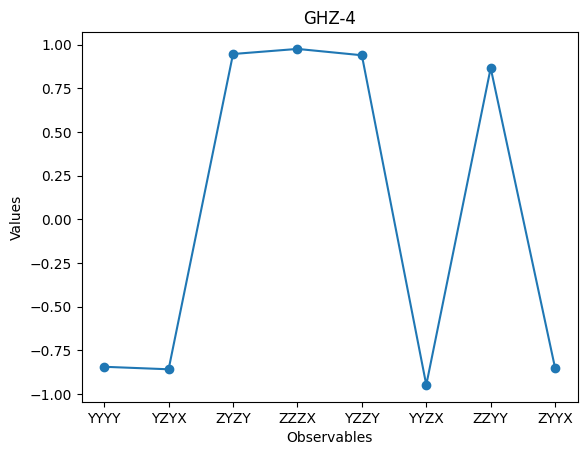

In [16]:
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.title('GHZ-4')
plt.show()